### Date: 05/16/2015 10 am

this notebook is to investigate into the response variables, and fix the specific metric to classify/regress against

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import requests
from pattern import web
import random

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [3]:
# read in the talk_df_small json file
talks = pd.read_json('talk_df_small.json')

## split out test set

In [14]:
talks.shape

(1885, 31)

In [15]:
testrows = random.sample(talks.index,350)

In [16]:
test = talks.ix[testrows]

In [17]:
train = talks.drop(testrows)

In [18]:
test.shape

(350, 31)

In [19]:
train.shape

(1535, 31)

### Save both test and train dataframe 

In [22]:
test.to_json('test.json')

In [23]:
train.to_json('train.json')

In [3]:
# read in the train set
train = pd.read_json('train.json')

In [4]:
train.reset_index(drop = True, inplace = True)

In [5]:
# select only the rating words
ratings = train.ix[:,:14]

In [6]:
ratings.shape

(1535, 14)

### read in test ratings 

In [411]:
test = pd.read_json('test.json')

In [412]:
test.reset_index(drop = True, inplace = True)

In [413]:
test_ratings = test.ix[:,:14]

In [414]:
test_ratings.shape

(350, 14)

##reduce the dimension of the multi-class problem 

###1. Cluster talks based on the rating words, then look at the rating words distribution in each cluster 

In [7]:
ratings = ratings.fillna(0)

In [8]:
# normalize against total ratings one talk receives
ratingsum = ratings.sum(axis = 1)

In [9]:
ratingsum.min()

176.0

In [10]:
ratingwords = list(ratings.columns)

In [11]:
ratings = ratings[ratingwords].div(ratingsum,axis = 'index')

In [12]:
ratings['id'] = train['id']
ratings.set_index('id',inplace = True)

In [13]:
ratings.head()

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
id,,,,,,,,,,,,,,
1,0.020121,0.020523,0.050704,0.040241,0.185111,0.154125,0.020121,0.143260,0.034205,0.038229,0.065996,0.046680,0.094567,0.086117
2,0.029782,0.000000,0.084712,0.091992,0.009927,0.156188,0.178028,0.285903,0.040371,0.009265,0.017869,0.001985,0.087359,0.006618
2167,0.015021,0.003577,0.019313,0.143777,0.010014,0.230329,0.173104,0.233190,0.016452,0.018598,0.037911,0.000715,0.077253,0.020744
3,0.047927,0.028497,0.159326,0.049223,0.011658,0.242228,0.034974,0.129534,0.037565,0.023316,0.054404,0.014249,0.129534,0.037565
99,0.137476,0.009416,0.022599,0.011299,0.431262,0.015066,0.077213,0.035782,0.009416,0.011299,0.131827,0.052731,0.024482,0.030132


In [14]:
ratingm = ratings.as_matrix()

In [15]:
ratingm.shape

(1535, 14)

###The same process with test ratings 

In [415]:
test_ratings = test_ratings.fillna(0)

In [416]:
test_r_sum = test_ratings.sum(axis = 1)

In [417]:
test_ratings = test_ratings[ratingwords].div(test_r_sum,axis = 'index')

In [418]:
test_ratings['id'] = test['id']
test_ratings.set_index('id',inplace = True)

In [419]:
test_ratingsm = test_ratings.as_matrix()

In [439]:
test_ratings.head(1)

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
id,,,,,,,,,,,,,,
1146,0.013372,0.006977,0.015116,0.25,0,0.138372,0.215698,0.081395,0.219186,0.01686,0.012209,0.006977,0.020349,0.003488


### scale ratingm, so that the low-freq words (negative ones) can have effects in variation

In [16]:
scaler = StandardScaler()

In [17]:
# scale ratingm along the feature columns, so that the low-freq words (negative ones) can have effects in variation
# ratingm_scaled = scale(ratingm)
scaler.fit(ratingm)
ratingm_scaled = scaler.transform(ratingm)

In [429]:
ratingm_scaled.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [19]:
ratingm_scaled.shape

(1535, 14)

###scale the test rating matrix with the same scaler 

In [430]:
test_ratingsm_scaled = scaler.transform(test_ratingsm)

##### Note the stds are not exactly one, but close enough

In [432]:
test_ratingsm_scaled.std(axis=0)

array([ 0.89602648,  0.7195226 ,  0.88194508,  0.96595317,  1.01244566,
        1.02365363,  0.91735001,  0.9867154 ,  0.96879184,  1.10958519,
        0.98588827,  1.16896152,  1.01695255,  0.94337894])

In [438]:
test_ratingsm_scaled.shape

(350, 14)

### Reduce dimension using PCA prior to clustering 

In [20]:
pca = PCA(n_components=8)
reduced = pca.fit_transform(ratingm_scaled)

In [21]:
print '{} variation has been explained by 10 components'.format(pca.explained_variance_ratio_.sum())

0.860651811267 variation has been explained by 10 components


### Reduce the dimension of test set using the same PCA 

In [476]:
reduced_test_ratingsm = pca.transform(test_ratingsm_scaled)

###Find the right number of clusters 

In [22]:
n_cluster = xrange(1,21)

In [33]:
inertias = []
for num in n_cluster:
    clf0 = KMeans(n_clusters = num,n_init = 30)
    clf0.fit(reduced)
    print 'the inertia is {} for {} cluters'.format(clf0.inertia_,num)
    inertias.append(clf0.inertia_)

the inertia is 18495.4074241 for 1 cluters
the inertia is 15195.0290181 for 2 cluters
the inertia is 12648.1683938 for 3 cluters
the inertia is 10874.4574054 for 4 cluters
the inertia is 9788.10966198 for 5 cluters
the inertia is 8989.84333516 for 6 cluters
the inertia is 8318.86759345 for 7 cluters
the inertia is 7819.90163291 for 8 cluters
the inertia is 7358.8188497 for 9 cluters
the inertia is 6940.19578224 for 10 cluters
the inertia is 6616.09650682 for 11 cluters
the inertia is 6403.13391032 for 12 cluters
the inertia is 6221.93070289 for 13 cluters
the inertia is 6051.23609475 for 14 cluters
the inertia is 5890.37229129 for 15 cluters
the inertia is 5737.98606432 for 16 cluters
the inertia is 5591.11808381 for 17 cluters
the inertia is 5453.3878212 for 18 cluters
the inertia is 5339.35684316 for 19 cluters
the inertia is 5210.64377632 for 20 cluters


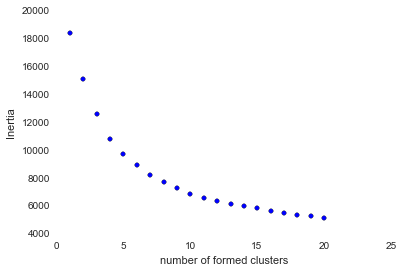

In [34]:
plt.scatter(x = n_cluster, y = inertias, marker = 'o')
plt.xlabel('number of formed clusters')
plt.ylabel('Inertia')

#### Choose 5 clusters, look at the centroids

In [384]:
clf = KMeans(n_clusters = 5,random_state=58)
clf.fit(reduced)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=58, tol=0.0001,
    verbose=0)

In [385]:
clf.inertia_

9788.0971657649752

In [386]:
len(clf.labels_)

1535

In [387]:
clf.labels_[0]

4

In [388]:
cents = clf.cluster_centers_

In [389]:
# get the original space
cents_ori = pca.inverse_transform(cents)

In [390]:
cents_ori.shape

(5, 14)

In [391]:
cents_ori_df = pd.DataFrame(cents_ori,columns = ratingwords)

In [392]:
cents_ori_df

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
0,-0.556412,-0.164345,-0.228553,0.047684,-0.255374,0.951846,-0.354386,-0.259143,-0.317342,0.029564,0.060195,-0.181935,0.874045,0.033963
1,0.703759,-0.413240,1.013337,-0.683771,-0.251029,-0.742740,-0.467599,1.150218,-0.173866,-0.330435,-0.439749,-0.276203,-0.108065,-0.418202
2,0.051366,-0.190492,-0.575455,1.034983,-0.188326,-0.175858,1.098766,-0.425898,1.036031,-0.411621,-0.425263,-0.387282,-0.672068,-0.367893
3,-0.165292,1.729411,-0.363531,-0.374332,-0.111561,-0.134240,-0.193229,-0.696899,-0.481320,1.586842,1.497543,1.490613,-0.347203,1.767707
4,-0.170562,0.073118,-0.406284,-0.340861,2.813481,-0.486866,0.064321,-0.730878,-0.531799,-0.127135,0.340642,0.647723,-0.609248,-0.247675


#### so the above five clusters indicate the following associations
2: (Fascinating, Ingenious, Jaw-dropping)

0: (Informative, Persuasive)

3: (confusing, longwinded, OK, Obnoxious, Unconvincing)

1: (Beautiful,Courageous,Inspiring)

4: (Funny)

#### For now, save labels as the response variable 

In [393]:
response = clf.labels_

In [394]:
type(response)

numpy.ndarray

In [395]:
response.shape

(1535,)

In [58]:
response = pd.Series(response,index = train['id'])

In [59]:
response.to_csv('response5.csv',index_label='id')

###Get the test labels through calculating their distance to each of the centroids, and get the smallest 

In [477]:
reduced_test_ratingsm.shape

(350, 8)

In [478]:
to_cents = clf.transform(reduced_test_ratingsm)

In [479]:
to_cents.shape

(350, 5)

In [480]:
to_cents = pd.DataFrame(to_cents, columns = [0,1,2,3,4])

In [481]:
to_cents.head(2)

,0,1,2,3,4
0,4.803445,5.391871,2.166353,6.492351,5.65912
1,2.726084,2.347600,4.255648,5.924577,5.17906


In [482]:
labels = []
for ind, row in to_cents.iterrows():
    label = row.idxmin()
    labels.append(label)

In [483]:
to_cents['label'] = labels

In [484]:
to_cents.head(10)

,0,1,2,3,4,label
0,4.803445,5.391871,2.166353,6.492351,5.659120,2
1,2.726084,2.347600,4.255648,5.924577,5.179060,1
2,3.584621,1.424049,4.216521,5.268421,4.742974,1
3,6.843279,6.818949,6.264815,7.476249,3.480401,4
4,4.434056,3.190355,2.838952,6.195582,5.233601,2
5,3.513637,4.263589,3.987027,3.203114,4.207114,3
6,2.427438,4.045582,3.891609,3.130650,3.258486,0
7,1.863545,2.768831,4.085037,4.889569,4.722872,0
8,4.361548,1.411188,4.342276,5.649748,5.050606,1
9,2.772204,4.108533,5.084775,6.004385,5.601200,0


In [485]:
test_ratings.head(10)

,Beautiful,Confusing,Courageous,Fascinating,Funny,Informative,Ingenious,Inspiring,Jaw-dropping,Longwinded,OK,Obnoxious,Persuasive,Unconvincing
id,,,,,,,,,,,,,,
1146,0.013372,0.006977,0.015116,0.250000,0.000000,0.138372,0.215698,0.081395,0.219186,0.016860,0.012209,0.006977,0.020349,0.003488
1153,0.032641,0.002967,0.096439,0.053412,0.000000,0.191395,0.014837,0.336795,0.059347,0.019288,0.007418,0.000000,0.182493,0.002967
1154,0.117083,0.007678,0.219770,0.078695,0.008637,0.131478,0.004798,0.272553,0.036468,0.016315,0.029750,0.013436,0.039347,0.023992
223,0.020984,0.001085,0.025326,0.093343,0.563314,0.003256,0.041245,0.020260,0.142547,0.019537,0.042692,0.016643,0.005065,0.004703
103,0.174612,0.004753,0.047113,0.149448,0.010206,0.054383,0.036488,0.249546,0.215714,0.013281,0.012303,0.002377,0.026422,0.003355
1187,0.141935,0.018065,0.009032,0.158710,0.014194,0.172903,0.038710,0.145806,0.024516,0.015484,0.147097,0.027097,0.025806,0.060645
105,0.011834,0.020710,0.012821,0.085799,0.126233,0.256410,0.061144,0.156805,0.014793,0.075937,0.061144,0.011834,0.064103,0.040434
1189,0.016807,0.017647,0.145378,0.083193,0.001681,0.190756,0.035294,0.182353,0.026891,0.015966,0.024370,0.006723,0.218487,0.034454
1193,0.242326,0.013034,0.148345,0.068599,0.003258,0.029326,0.020580,0.324130,0.040302,0.016121,0.019894,0.009089,0.048705,0.016292


In [488]:
test_response = pd.Series(labels,index = test['id'])

In [490]:
test_response.to_csv('test_response.csv',index_label='id')